https://www.kaggle.com/competitions/ieee-fraud-detection

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Resample
        * Random UnderSampling (RUS)
        * Near Miss
        * Instance Hardness Threshold
    * Oversample
        * Resample
        * Random OverSampling (ROS)
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
    * Métricas de desempenho por threshold (0,05 a 0,50) e por técnica de balanceamento
        * F1-score positivo (iteração por iteração)
        * Wall time

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
creditcard = pd.read_csv(f'{folder_path}creditcard.csv')

# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(creditcard)

Dataset Shape: (284807, 31)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Time,float64,0,124592,0.000000000000000,0.000000000000000,1.000000000000000,16.690000000000001
1,V1,float64,0,275663,-1.359807133673800,1.191857111314860,-1.358354061598230,18.030000000000001
2,V2,float64,0,275663,-0.072781173309850,0.266150712059630,-1.340163074736090,18.030000000000001
3,V3,float64,0,275663,2.536346737969140,0.166480113353210,1.773209342631190,18.030000000000001
4,V4,float64,0,275663,1.378155224274430,0.448154078460911,0.379779593034328,18.030000000000001
5,V5,float64,0,275663,-0.338320769942518,0.060017649282224,-0.503198133318193,18.030000000000001
6,V6,float64,0,275663,0.462387777762292,-0.082360808815569,1.800499380792630,18.030000000000001
7,V7,float64,0,275663,0.239598554061257,-0.078802983332311,0.791460956450422,18.030000000000001
8,V8,float64,0,275663,0.098697901261051,0.085101654914810,0.247675786588991,18.030000000000001
9,V9,float64,0,275663,0.363786969611213,-0.255425128109186,-1.514654322605830,18.030000000000001


In [10]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [11]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


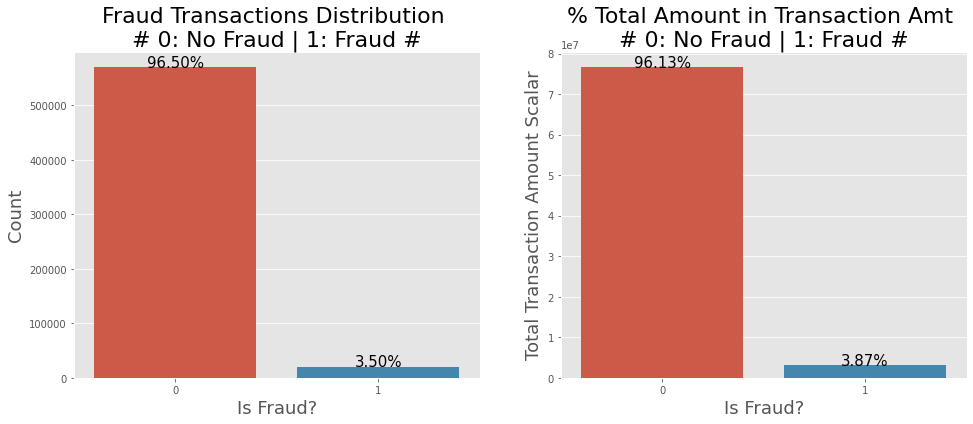

In [12]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

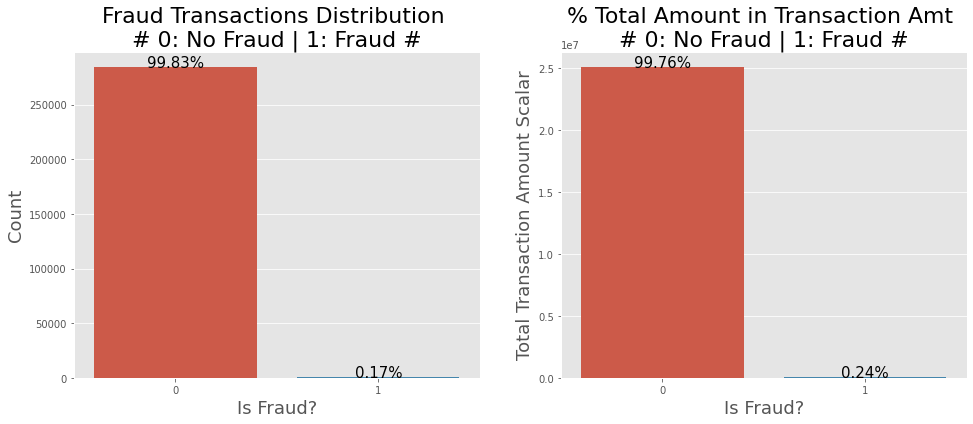

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
creditcard['Amount'] = creditcard['Amount'].astype(float)
total = len(creditcard)
total_amt = creditcard.groupby(['Class'])['Amount'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'Class', data = creditcard, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (creditcard.groupby(['Class'])['Amount'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'Class', y = 'Amount', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering (Dataset 01)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_28: 76.12727334304196%
id_29: 76.12727334304196%
id_30: 86.86541131845429%
id_31: 76.24513157449114%
id_32: 86.86185525112609%
id_33: 87.58949436109323%
id_34: 86.82477054898906%
id_35: 76.12608798726589%
id_36: 76.12608798726589%
id_37: 76.12608798726589%
id_38: 76.12608798726589%
DeviceType: 76.15572188166763%
DeviceInfo: 79.90551021099333%
Date: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 01)

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#X_train = train_split.drop('isFraud',axis = 1)
#y_train = train_split['isFraud'].astype('uint8')

#X_test = test_split.drop('isFraud', axis = 1)
#y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
#print("Distribuição das classes no conjunto de treinamento:")
#print(y_train.value_counts())

#print("\nDistribuição das classes no conjunto de teste:")
#print(y_test.value_counts())

In [58]:
# combinando as classes minoritária com a majoritária subamostrada
#test_split = pd.concat([X_test, y_test], \
#                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#test_split.isFraud.value_counts()

# Feature Engineering (Dataset 02)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [59]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

#import datetime

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#train['_Weekdays'] = train['Date'].dt.dayofweek
#train['_Hours'] = train['Date'].dt.hour
#train['_Days'] = train['Date'].dt.day

In [60]:
# fazendo o mesmo para base teste

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#test['_Weekdays'] = test['Date'].dt.dayofweek
#test['_Hours'] = test['Date'].dt.hour
#test['_Days'] = test['Date'].dt.day

In [61]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
#pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [62]:
# importante para seguir com ajustes na base de forma otimizada
#train.columns.difference(test.columns)

In [63]:
# ajustar colunas de teste
#test.columns = test.columns.str.replace('-', '_')

In [64]:
# checando resultado final das diferenças
#train.columns.difference(test.columns)

## Tratando Colunas com Valores Faltantes

In [65]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [66]:
# lista completa de colunas com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [67]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_creditcard = [col for col in creditcard.columns if creditcard[col].isnull().sum() / creditcard.shape[0] > 0.75]
#many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [68]:
# checando se existem colunas apenas com um valor
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_creditcard)} columns in creditcard dataset with one unique value.')
#print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in creditcard dataset with one unique value.


In [69]:
# identificando colunas com valor único
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [70]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_creditcard = [col for col in creditcard.columns if \
                            creditcard[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
#big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
#                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [71]:
cols_to_drop = list(set(many_null_cols_creditcard + big_top_value_cols_creditcard + \
                        one_value_cols_creditcard))# + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'Class' da remoção
cols_to_drop.remove('Class')
len(cols_to_drop)

0

In [72]:
creditcard = creditcard.drop(cols_to_drop, axis=1)
#test = test.drop(cols_to_drop, axis=1)

In [73]:
# checando novamente a diferença entre colunas das bases treino e teste
#train.columns.difference(test.columns)

## Identificando Linhas com Valores Faltantes e Removendo-as

In [74]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * creditcard.shape[1] + 1)
creditcard = creditcard.dropna(axis = 0, thresh = min_count)

#min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
#test = test.dropna(axis = 0, thresh = min_count)

In [75]:
creditcard.shape

(284807, 31)

In [76]:
#test.shape

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [77]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
#train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
#test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [78]:
# checando por diferenças de colunas entre as bases de treino e teste
#train.columns.difference(test.columns)

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [79]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [80]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(creditcard)

Dataset Shape: (284807, 31)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Time,float64,0,124592,0.000000000000000,0.000000000000000,1.000000000000000,16.690000000000001
1,V1,float64,0,275663,-1.359807133673800,1.191857111314860,-1.358354061598230,18.030000000000001
2,V2,float64,0,275663,-0.072781173309850,0.266150712059630,-1.340163074736090,18.030000000000001
3,V3,float64,0,275663,2.536346737969140,0.166480113353210,1.773209342631190,18.030000000000001
4,V4,float64,0,275663,1.378155224274430,0.448154078460911,0.379779593034328,18.030000000000001
5,V5,float64,0,275663,-0.338320769942518,0.060017649282224,-0.503198133318193,18.030000000000001
6,V6,float64,0,275663,0.462387777762292,-0.082360808815569,1.800499380792630,18.030000000000001
7,V7,float64,0,275663,0.239598554061257,-0.078802983332311,0.791460956450422,18.030000000000001
8,V8,float64,0,275663,0.098697901261051,0.085101654914810,0.247675786588991,18.030000000000001
9,V9,float64,0,275663,0.363786969611213,-0.255425128109186,-1.514654322605830,18.030000000000001


In [81]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [82]:
creditcard = replace_missing_values(creditcard)

In [83]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [84]:
#test = replace_missing_values(test)

In [85]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [86]:
# identificando os atributos classificados como "object" para codificação
object_columns = creditcard.select_dtypes(include = "object").columns
print(object_columns)

Index([], dtype='object')


In [87]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
#object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
#       'M5', 'M6', 'M7', 'M8', 'M9']

In [88]:
# Aplicando One-Hot Encoding em várias colunas
#creditcard = pd.get_dummies(creditcard, columns = object_columns_treated)
#test = pd.get_dummies(test, columns = object_columns_treated)

In [89]:
# checando se ainda existem colunas "object"
checking_remaining_objects_creditcard = resumetable(creditcard)[['Name', 'dtypes']]
checking_remaining_objects_creditcard[checking_remaining_objects_creditcard['dtypes'] == 'object']

Dataset Shape: (284807, 31)


,Name,dtypes


In [90]:
# checando se ainda existem colunas "object"
#checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
#checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

In [91]:
# checando se ainda existem colunas categóricas
cols = creditcard.columns
num_cols = creditcard._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [92]:
# checando se ainda existem colunas categóricas
#cols = test.columns
#num_cols = test._get_numeric_data().columns
#cat_cols = list(set(cols) - set(num_cols))
#cat_cols

In [93]:
# checando por diferenças entre as colunas de treino e teste
#train.columns.difference(test.columns)

## Checando colunas com valores negativos para métodos de seleção de atributos

In [94]:
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


In [95]:
# separando as columas com valores negativos
#negative_columns_treated = ['D4', 'D11', 'D15']

In [96]:
# realizando a transformação
#le = LabelEncoder()
#for col in negative_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [97]:
# última checagem de valores negativos
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


In [98]:
# última checagem de valores negativos
#columns_negative_values = test.columns[test.lt(0).any()]
#print("Columns with negative values:", columns_negative_values)

# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 02)

In [99]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(creditcard, test_size=0.2, random_state=42, stratify = creditcard.Class)

In [100]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('Class',axis = 1)
y_train = train_split['Class'].astype('uint8')

X_test = test_split.drop('Class', axis = 1)
y_test = test_split['Class'].astype('uint8')

In [101]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
Class
0    227451
1       394
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
Class
0    56864
1       98
Name: count, dtype: int64


In [102]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.Class.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

# Balanceamento de Classes (Datasets 01 e 02)

### Undersample com Resample

In [103]:
%%time

from sklearn.utils import resample

not_fraud = train_split[train_split.Class == 0]
fraud = train_split[train_split.Class == 1]


not_fraud_undersampled = resample(not_fraud,
                                  replace = False, # sample without replacement
                                  n_samples = len(fraud), # match minority n
                                  random_state = 27)



# combinando as classes minoritária com majoritária subamostrada 
undersample_with_resample = pd.concat([not_fraud_undersampled, fraud])

#X_train_undersample_with_resample = undersample_with_resample.drop('isFraud',axis = 1)
#y_train_undersample_with_resample = undersample_with_resample['isFraud'].astype('uint8')

X_train_undersample_with_resample = undersample_with_resample.drop('Class',axis = 1)
y_train_undersample_with_resample = undersample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
#undersample_with_resample.isFraud.value_counts()
undersample_with_resample.Class.value_counts()

CPU times: user 43.7 ms, sys: 0 ns, total: 43.7 ms
Wall time: 43.3 ms


Class
0    394
1    394
Name: count, dtype: int64

### Undersample com Random Undersampling (RUS)

In [104]:
%%time

import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_train_undersample_with_rus, y_train_undersample_with_rus = rus.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada 
undersample_with_rus = pd.concat([X_train_undersample_with_rus, y_train_undersample_with_rus], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#undersample_with_rus.isFraud.value_counts()
undersample_with_rus.Class.value_counts()

CPU times: user 89.5 ms, sys: 3.8 ms, total: 93.3 ms
Wall time: 92.4 ms


Class
0    394
1    394
Name: count, dtype: int64

### Undersample com Near Miss

In [105]:
%%time

from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#undersample_with_near_miss.isFraud.value_counts()
undersample_with_near_miss.Class.value_counts()

CPU times: user 1.34 s, sys: 583 ms, total: 1.92 s
Wall time: 355 ms


Class
0    394
1    394
Name: count, dtype: int64

### Undersample com Instance Hardness Threshold

In [106]:
%%time

from imblearn.under_sampling import InstanceHardnessThreshold

iht = InstanceHardnessThreshold(random_state=42)

X_train_undersample_with_iht, y_train_undersample_with_iht = iht.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_iht = pd.concat([X_train_undersample_with_iht, \
                                        y_train_undersample_with_iht], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#undersample_with_iht.isFraud.value_counts()
undersample_with_iht.Class.value_counts()

CPU times: user 9min, sys: 27.6 ms, total: 9min
Wall time: 9min


Class
0    221876
1       394
Name: count, dtype: int64

### Oversample com Resample

In [107]:
%%time

fraud_upsampled = resample(fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(not_fraud), # match number in majority class
                           random_state = 27)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_resample = pd.concat([not_fraud, fraud_upsampled])

#X_train_oversample_with_resample = oversample_with_resample.drop('isFraud',axis = 1)
#y_train_oversample_with_resample = oversample_with_resample['isFraud'].astype('uint8')

X_train_oversample_with_resample = oversample_with_resample.drop('Class',axis = 1)
y_train_oversample_with_resample = oversample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
#oversample_with_resample.isFraud.value_counts()
oversample_with_resample.Class.value_counts()

CPU times: user 31.7 ms, sys: 16 ms, total: 47.7 ms
Wall time: 46.9 ms


Class
0    227451
1    227451
Name: count, dtype: int64

### Oversample com Random Oversampling (ROS)

In [108]:
%%time

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#oversample_with_ros.isFraud.value_counts()
oversample_with_ros.Class.value_counts()

CPU times: user 197 ms, sys: 36 ms, total: 233 ms
Wall time: 232 ms


Class
0    227451
1    227451
Name: count, dtype: int64

### Oversampling com SMOTE

In [109]:
%%time

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#train_oversample_with_smote.isFraud.value_counts()
train_oversample_with_smote.Class.value_counts()

CPU times: user 172 ms, sys: 44.1 ms, total: 216 ms
Wall time: 199 ms


Class
0    227451
1    227451
Name: count, dtype: int64

### Oversample com Borderline SMOTE

In [110]:
%%time

from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                   y_train_oversample_with_borderline_smote], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#oversample_with_borderline_smote.isFraud.value_counts()
oversample_with_borderline_smote.Class.value_counts()

CPU times: user 912 ms, sys: 23.9 ms, total: 935 ms
Wall time: 274 ms


Class
0    227451
1    227451
Name: count, dtype: int64

### Oversampling com AdaSyn

In [111]:
%%time

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)

X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#train_oversample_with_adasyn.isFraud.value_counts()
train_oversample_with_adasyn.Class.value_counts()

CPU times: user 889 ms, sys: 48.1 ms, total: 937 ms
Wall time: 270 ms


Class
0    227451
1    227346
Name: count, dtype: int64

In [112]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 6.3e+02 s


# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [113]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [115]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [116]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

## Validação Cruzada para Diferentes Limiares

### Todas as colunas

In [117]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

CPU times: user 20.5 s, sys: 7.96 ms, total: 20.5 s
Wall time: 20.5 s


,Threshold: 0.05,Threshold: 0.1,Threshold: 0.15,Threshold: 0.2,Threshold: 0.25,Threshold: 0.3,Threshold: 0.35,Threshold: 0.4,Threshold: 0.45,Threshold: 0.5,Threshold: 0.55,Threshold: 0.6,Threshold: 0.65,Threshold: 0.7,Threshold: 0.75
0,[0.6650811688311689],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,[0.8272022777629185],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,[0.8439044804524682],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,[0.8684465173629261],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,[0.8690016708437762],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,[0.8719394073418844],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,[0.8808282962307731],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.8898508526217507],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.8882886136910905],NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.8704314708339478],NaN,NaN,NaN,NaN,NaN


In [118]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

CPU times: user 16.2 s, sys: 0 ns, total: 16.2 s
Wall time: 16.2 s


,Threshold: 0.05,Threshold: 0.1,Threshold: 0.15,Threshold: 0.2,Threshold: 0.25,Threshold: 0.3,Threshold: 0.35,Threshold: 0.4,Threshold: 0.45,Threshold: 0.5,Threshold: 0.55,Threshold: 0.6,Threshold: 0.65,Threshold: 0.7,Threshold: 0.75
0,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.733287910060356],NaN,NaN,NaN,NaN,NaN


## Validação Cruzada para Undersampling com Resample

In [119]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [120]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 16.5 s, sys: 0 ns, total: 16.5 s
Wall time: 16.5 s


In [121]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


## Validação Cruzada para Undersampling com RUS

In [122]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [123]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 16.7 s


In [124]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


## Validação Cruzada para Undersampling com Near Miss

In [125]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [126]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 16.7 s


In [127]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


## Validação Cruzada para Undersampling com IHT

In [128]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [129]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 27.6 s, sys: 7.9 ms, total: 27.7 s
Wall time: 27.7 s


In [130]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 30.8 s, sys: 0 ns, total: 30.8 s
Wall time: 30.8 s


## Validação Cruzada para Oversampling com Resample

In [131]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [132]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 39.3 s, sys: 3.89 ms, total: 39.3 s
Wall time: 39.3 s


In [133]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 24.5 s, sys: 0 ns, total: 24.5 s
Wall time: 24.5 s


## Validação Cruzada para Oversampling com Random OverSampling (ROS)

In [134]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [135]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 39.5 s, sys: 27.9 ms, total: 39.5 s
Wall time: 39.5 s


In [136]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 24.7 s, sys: 0 ns, total: 24.7 s
Wall time: 24.7 s


## Validação Cruzada para Oversampling com SMOTE

In [137]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [138]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 42.4 s, sys: 20 ms, total: 42.5 s
Wall time: 42.4 s


In [139]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 44.9 s, sys: 7.97 ms, total: 44.9 s
Wall time: 44.9 s


## Validação Cruzada para Oversample com Borderline SMOTE

In [140]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [141]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 35.9 s, sys: 32 ms, total: 36 s
Wall time: 36 s


In [142]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 46.6 s, sys: 12 ms, total: 46.7 s
Wall time: 46.7 s


## Validação Cruzada para Oversample com AdaSyn

In [143]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)

In [144]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7983328419086934
F1-Score Positivo Fold 1: 0.8235294117647058
F1-Score Positivo Fold 2: 0.5714285714285715
F1-Score Positivo Fold 3: 0.5714285714285714
F1-Score Positivo Fold 4: 1.0
F1-Score Positivo Fold 5: 0.8235294117647058
F1-Score Positivo Fold 6: 0.7777777777777777
F1-Score Positivo Fold 7: 0.8235294117647058
F1-Score Positivo Fold 8: 1.0
F1-Score Positivo Fold 9: 0.8421052631578948
F1-Score Positivo Fold 10: 0.7499999999999999
CPU times: user 39.2 s, sys: 7.96 ms, total: 39.2 s
Wall time: 39.2 s


In [145]:
%%time

# Crie uma instância de StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")

F1-Score Positivo Médio (Validação Cruzada): 0.7165622612681436
F1-Score Positivo Fold 1: 0.7058823529411764
F1-Score Positivo Fold 2: 0.5
F1-Score Positivo Fold 3: 0.7142857142857143
F1-Score Positivo Fold 4: 0.9
F1-Score Positivo Fold 5: 0.8000000000000002
F1-Score Positivo Fold 6: 0.8000000000000002
F1-Score Positivo Fold 7: 0.6363636363636365
F1-Score Positivo Fold 8: 0.9090909090909091
F1-Score Positivo Fold 9: 0.7
F1-Score Positivo Fold 10: 0.5
CPU times: user 47.9 s, sys: 3.98 ms, total: 47.9 s
Wall time: 47.9 s


# Cálculo tempo total do script

In [146]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+03 s
